# Example parsing cobaya/getdist chains and getting GLM quantities:

In [134]:
%reload_ext autoreload
%autoreload 2

import matplotlib as mpl
import os
import matplotlib.pyplot as plt

In [135]:
# initial imports:
import sys, os
import matplotlib.pyplot as plt

# getdist imports:
from getdist import plots, MCSamples

# tensiometer local imports:
here = os.path.dirname(os.getcwd())
tensiometer_path = os.path.join(here, 'tensiometer')
sys.path.append(tensiometer_path)

import tensiometer
print('Tensiometer version:', tensiometer.__version__)
print('Tensiometer path:', tensiometer.__path__)

Tensiometer version: 1.0.2
Tensiometer path: ['/Users/marco/Desktop/IW/ParametricModels/tensiometer/tensiometer']


## Parsing the chains:

In [4]:
# chains paths:

chains_dir = os.path.join('chains')

In [5]:
# getdist settings:

getdist_settings = {
    'smooth_scale_1D': 0.3,
    'smooth_scale_2D': 0.4,
    'boundary_correction_order': 1,
    'mult_bias_correction_order': 1,
    }

In [6]:
# import chain
from cobaya import load_samples

name = '04p1_LCDM_CMB_BAO_SN'
chain = load_samples(os.path.join(chains_dir, name), skip=0.3, to_getdist=True)
chain.label = name
chain.root = os.path.join(chains_dir, name)
chain.updateSettings(getdist_settings)
chain.updateBaseStatistics()
chain.getConvergeTests()
print(chain.label+': R =', round(chain.GelmanRubin, 4))

04p1_LCDM_CMB_BAO_SN: R = 0.0085


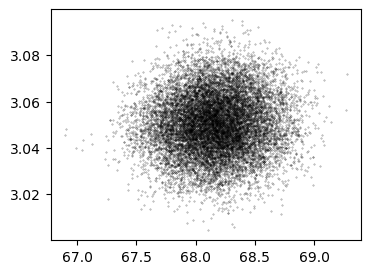

In [10]:
plt.figure(figsize=(4, 3))
plt.scatter(chain.samples[:, 0], chain.samples[:, 1], s=0.1, c='k', alpha=0.5)

## Parsing the model:

In [15]:
# rebuild the model:
from cobaya.model import get_model
import yaml

# define the path to the YAML parameters file:
yaml_params = os.path.join(chains_dir, name + '.input.yaml')
print('YAML parameters file:', yaml_params)
# load the parameters from the YAML file:
with open(yaml_params, 'r') as f:
    params_dict = yaml.safe_load(f)
# remove the 'path' key from the 'camb' dictionary if it exists:
if 'path' in params_dict.get('theory', {}).get('camb', {}):
    del params_dict['theory']['camb']['path']
if 'recombination_model' in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['recombination_model']
    print('Removed "recombination_model" from the "camb" extra_args in the YAML parameters file.')
if 'max_zrei'in params_dict.get('theory', {}).get('camb', {}).get('extra_args', {}):
    del params_dict['theory']['camb']['extra_args']['max_zrei']
    print('Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.')
    
# build the model:
model = get_model(params_dict)

YAML parameters file: chains/04p1_LCDM_CMB_BAO_SN.input.yaml
Removed "recombination_model" from the "camb" extra_args in the YAML parameters file.
Removed "max_zrei" from the "camb" extra_args in the YAML parameters file.


[model] *WARNING* Ignored blocks/options: ['sampler', 'output']


INFO:camb:`camb` module loaded successfully from /Users/marco/Software/cobaya/code/CAMB/camb


[camb] `camb` module loaded successfully from /Users/marco/Software/cobaya/code/CAMB/camb


/Users/marco/Software/anaconda3/lib/python3.9/site-packages/sacc/sacc.py:935: UserWarning: The FITS format without the 'sacc_ordering' column is deprecated. Assuming data rows are in the correct order as it was before version 1.0.
  warnings.warn(
INFO:planck_2020_lollipop.lowleb:Initialized!


[planck_2020_lollipop.lowleb] Initialized!


INFO:bao.desi_dr2.desi_bao_all:Initialized.


[bao.desi_dr2.desi_bao_all] Initialized.


In [16]:
params = model.parameterization.sampled_params()
print(params)

{'H0': nan, 'logA': nan, 'ns': nan, 'ombh2': nan, 'omch2': nan, 'tau': nan, 'A_planck': nan, 'P_act': nan}


In [17]:
for p in params.keys():
    params[p] = BestFitDict[p]  # Set the best fit values for all parameters

In [18]:
print(params)

{'H0': 68.15716366, 'logA': 3.050066145, 'ns': 0.9711848476, 'ombh2': 0.02244360523, 'omch2': 0.117889913, 'tau': 0.06046932587, 'A_planck': 0.9996523913, 'P_act': 1.003520856}


In [19]:
import numpy as np

loglikes = []

# Now scan over H0
H0_vals = np.linspace(60, 80, 10)

# Loop over H0 values and compute log posterior
for H0 in H0_vals:
    
    params['H0'] = H0  # Set the current value of H0

    # Fix other params if needed
    loglike = model.loglike(params, return_derived=False)  # log posterior = log prior + log likelihood
    loglikes.append(loglike)

## GLM reverse engineering

In the following sections x_obs is the observed data, x_model is the model prediction, Sigma is data covariance.

### BAO measurements:

In [80]:
name = 'bao.desi_dr2.desi_bao_all'
component = [_comp for _comp in model.components if _comp.__dict__.get('_name') == name][0]

In [84]:
# measured data:
x_obs = component.data["value"].values
# Data covariance matrix:
Sigma_inv = component.invcov
Sigma = np.linalg.inv(Sigma_inv)

In [82]:
# how to calculate model predictions:
model.loglike(params, return_derived=False)  # call full model likelihood to initialize all internal caches
# extract the model predictions:
x_model = np.array([component.theory_fun(z, obs) for z, obs in zip(component.data["z"], component.data["observable"])]).T[0]

In [85]:
# check that the likelihood is correct:
reversed_loglike = -0.5 * np.dot((x_obs - x_model).T, np.dot(Sigma_inv, (x_obs - x_model)))
print("Reversed log-likelihood:", reversed_loglike)
print("Model log-likelihood:", component.logp())

Reversed log-likelihood: -480.22139375578337
Model log-likelihood: -480.22139375578337


### SN measurements:

In [89]:
name = 'sn.desy5'
component = [_comp for _comp in model.components if _comp.__dict__.get('_name') == name][0]

In [92]:
# measured data:
x_obs = component.mag
# Data covariance matrix:
Sigma_inv = component.invcov
Sigma = np.linalg.inv(Sigma_inv)

In [93]:
# how to calculate model predictions:
model.loglike(params, return_derived=False)  # call full model likelihood to initialize all internal caches
# extract model prediction (lots of black magic here):
angular_diameter_distances = component.provider.get_angular_diameter_distance(component.zcmb)
lumdists = (5 * np.log10((1 + component.zhel) * (1 + component.zcmb) * angular_diameter_distances))
invvars = 1.0 / component.pre_vars
wtval = np.sum(invvars)
estimated_scriptm = np.sum((component.mag - lumdists) * invvars) / wtval
#
x_model = lumdists + estimated_scriptm

In [94]:
# check that the likelihood is correct:
reversed_loglike = -0.5 * np.dot((x_obs - x_model).T, np.dot(Sigma_inv, (x_obs - x_model)))
print("Reversed log-likelihood:", reversed_loglike)
print("Model log-likelihood:", component.logp())

Reversed log-likelihood: -857.4599811427858
Model log-likelihood: -857.4599811429276


### Planck intermediate scales:

In [100]:
name = 'act_dr6_cmbonly.PlanckActCut'
component = [_comp for _comp in model.components if _comp.__dict__.get('_name') == name][0]

In [101]:
# measured data:
x_obs = component.X_data
# Data covariance matrix:
Sigma_inv = component.invcov
Sigma = np.linalg.inv(Sigma_inv)

In [102]:
# how to calculate model predictions:
model.loglike(params, return_derived=False)  # call full model likelihood to initialize all internal caches
# extract model prediction (lots of black magic here):
A_planck = component._current_state['params']['A_planck']
L0 = 0
Cls = component.provider.get_Cl(ell_factor=True)
cl = np.empty(component.used_indices.shape)
ix = 0
for tp, cell in enumerate([Cls.get('tt'), Cls.get('te'), Cls.get('ee')]):
    for i in component.used_bins[tp]:
        cl[ix] = np.dot(cell[component.blmin[i] - L0:component.blmax[i] - L0 + 1],
                        component.weights[component.blmin[i]:component.blmax[i] + 1])
        ix += 1
cl /= A_planck ** 2
x_model = cl

In [103]:
# check that the likelihood is correct:
reversed_loglike = -0.5 * np.dot((x_obs - x_model).T, np.dot(Sigma_inv, (x_obs - x_model)))
print("Reversed log-likelihood:", reversed_loglike)
print("Model log-likelihood:", component.logp(A_planck=A_planck))  # note A_planck here

Reversed log-likelihood: -2323.4131269368145
Model log-likelihood: -2323.4131269368145


### ACT small scales:

In [106]:
name = 'act_dr6_cmbonly.ACTDR6CMBonly'
component = [_comp for _comp in model.components if _comp.__dict__.get('_name') == name][0]

In [110]:
# measured data:
x_obs = component.data_vec
# Data covariance matrix:
Sigma_inv = component.inv_cov
Sigma = np.linalg.inv(Sigma_inv)

In [113]:
# how to calculate model predictions:
model.loglike(params, return_derived=False)  # call full model likelihood to initialize all internal caches
# extract model prediction (lots of black magic here):
A_act = component._current_state['params']['A_act']
P_act = component._current_state['params']['P_act']
cl = component.provider.get_Cl(ell_factor=True)
ps_vec = np.zeros_like(component.data_vec)
for m in component.spec_meta:
    idx = m["idx"]
    win = m["window"].weight.T
    ls = m["window"].values
    pol = m["pol"]
    dat = cl[pol][ls] / (A_act * A_act)
    if pol[0] == "e":
        dat /= P_act
    if pol[1] == "e":
        dat /= P_act
    ps_vec[idx] = win @ dat
x_model = ps_vec

In [114]:
# check that the likelihood is correct:
reversed_loglike = -0.5 * np.dot((x_obs - x_model).T, np.dot(Sigma_inv, (x_obs - x_model)))
print("Reversed log-likelihood:", reversed_loglike)
print("Model log-likelihood:", component.logp(A_act=A_act, P_act=P_act))  # note A_planck here

Reversed log-likelihood: -5465.117847457552
Model log-likelihood: -5465.117847457552


### LowL TT likelihood:

In [116]:
name = 'planck_2018_lowl.TT'
component = [_comp for _comp in model.components if _comp.__dict__.get('_name') == name][0]

In [119]:
# measured data:
x_obs = component._mu
# Data covariance matrix:
Sigma_inv = component._covinv
Sigma = np.linalg.inv(Sigma_inv)

In [121]:
# how to calculate model predictions:
model.loglike(params, return_derived=False)  # call full model likelihood to initialize all internal caches
# extract model prediction (lots of black magic here):
A_planck = component._current_state['params']['A_planck']
cl = component.provider.get_Cl(ell_factor=True)['tt']
theory: np.ndarray = cl[component.lmin:component.lmax + 1] / A_planck ** 2
logl = 0.
# Convert the cl's to Gaussianized variables
x = np.zeros_like(theory)
for i, (spline, diff_spline, cl) in enumerate(
        zip(component._spline, component._spline_derivative, theory)):
    dxdCl = diff_spline(cl)
    logl += np.log(dxdCl)
    x[i] = spline(cl)
x_model = x

In [125]:
# check that the likelihood is correct:
reversed_loglike = -0.5 * np.dot((x_obs - x_model).T, np.dot(Sigma_inv, (x_obs - x_model)))
reversed_loglike += logl
reversed_loglike -= component._offset
print("Reversed log-likelihood:", reversed_loglike)
print("Model log-likelihood:", component.logp(A_planck=A_planck))  # note A_planck here

Reversed log-likelihood: -12.486550953681643
Model log-likelihood: -12.486550953681643


I do not entirely understand the offset here, see what happens...

### CMB lollipop:

In [127]:
name = 'planck_2020_lollipop.lowlEB'
component = [_comp for _comp in model.components if _comp.__dict__.get('_name') == name][0]

In [ ]:
# measured data:
x_obs = component._mu
# Data covariance matrix:
Sigma_inv = component._covinv
Sigma = np.linalg.inv(Sigma_inv)

In [128]:
component.__dict__

{'delay': 0,
 '_measured_speed': None,
 '_name': 'planck_2020_lollipop.lowlEB',
 'packages_path': '/Users/marco/Software/cobaya',
 'data_folder': '/Users/marco/Software/cobaya/data/planck_2020/lollipop',
 'cl_file': 'cl_lolEB_NPIPE.dat',
 'fiducial_file': 'fiducial_lolEB_planck2018_tensor_lensedCls.dat',
 'cl_cov_file': 'clcov_lolEB_NPIPE.fits',
 'hartlap_factor': False,
 'marginalised_over_covariance': True,
 'Nsim': 400,
 'lmin': 2,
 'lmax': 30,
 'params': {'A_planck': {'prior': {'dist': 'norm', 'loc': 1, 'scale': 0.0025},
   'ref': {'dist': 'norm', 'loc': 1, 'scale': 0.002},
   'proposal': 0.0005,
   'latex': 'y_\\mathrm{cal}',
   'renames': 'calPlanck'}},
 'type': [],
 'speed': -1,
 'stop_at_error': False,
 'version': None,
 'log': <Logger planck_2020_lollipop.lowleb (INFO)>,
 'timer': None,
 'mode': 'lowlEB',
 'bins': <planck_2020_lollipop.bins.Bins at 0x1ab2899a0>,
 'cldata': array([[ 4.20319189e-02,  6.54146610e-03,  7.65642488e-03,
          1.08042897e-02,  7.95095755e-04,  2.

In [132]:
import planck_2020_lollipop

In [133]:
planck_2020_lollipop.__path__

['/Users/marco/Software/anaconda3/lib/python3.9/site-packages/planck_2020_lollipop']